In [2]:
import sys
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy.ndimage import zoom
from scipy import spatial
from copy import copy
import shapefile
from shapely.geometry import Point
from shapely.geometry import shape
import subprocess
from IPython.display import display, clear_output #needed for animated plots
from inpaint_nans import inpaint_nans

import scipy.sparse as sps
from scipy.sparse import linalg
import numpy as np
from numpy import matlib


In [3]:
nan_value = -9999
resample = .5
res = 32.625 / resample

S_ref = np.flip(np.loadtxt("02_surface_Synthetic1_0000_UTM00.asc", skiprows=6), axis=0)
S_ref[S_ref == nan_value] = 0
S_ref = zoom(S_ref, resample)*10/9 # change resolution and convert to meter ice equivalent
M_ref = np.flip(np.loadtxt("04_mb_Synthetic1_0000-0001_UTM00.asc", skiprows=6), axis=0)
M_ref[M_ref == nan_value] = 0
M_ref = zoom(M_ref, resample)
dhdt_ref = np.flip(np.loadtxt("05_dhdt_Synthetic1_0000-0001_UTM00.asc", skiprows=6), axis=0)
dhdt_ref[dhdt_ref == nan_value] = 0
dhdt_ref = zoom(dhdt_ref, resample)
u_ref = np.flip(np.loadtxt("06_speed_Synthetic1_0000_UTM00.asc", skiprows=6), axis=0)
u_ref[u_ref == nan_value] = 0
u_ref = zoom(u_ref, resample)
az_ref = np.flip(np.loadtxt("07_azimuth_Synthetic1_0000_UTM00.asc", skiprows=6), axis=0)
az_ref[az_ref == nan_value] = 0
az_ref = zoom(az_ref, resample)
u_vel_ref = np.cos(1-np.deg2rad(az_ref))*u_ref
v_vel_ref = np.cos(np.deg2rad(az_ref))*u_ref

ny, nx = np.shape(S_ref)

outline = shapefile.Reader("./shapefiles/01_margin_Synthetic1_0000_UTM00.shp").shapes()[0]
mask = np.zeros_like(S_ref)
for j in range(np.shape(mask)[0]):
    for k in range(np.shape(mask)[1]):
        if Point([((k-6*resample)*res)+outline.bbox[0],((j-10*resample)*res)+outline.bbox[1]]).within(shape(outline)):
            mask[j,k] = 1

In [4]:
print(np.sum((dhdt_ref[mask==1]))*res**2)
print(np.sum((M_ref[mask==1]))*res**2)

-5980907.550915016
-4927270.1892443765


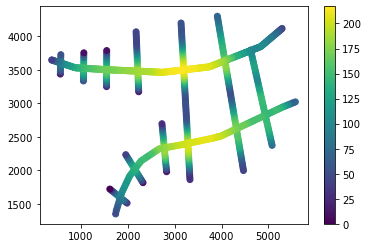

In [5]:
pNR, dist, x_coord, y_coord, z_surf, z_bed, thick = np.loadtxt("03_RES_Synthetic1_UTM00.txt", skiprows=17, unpack=True)
Pro = np.unique(pNR)
nPro = len(Pro)
indPro = []
count = 0
for i in Pro:
    indPro.append(np.where(pNR==i))
    count+=i

fig, ax = plt.subplots()
field = ax.scatter(x_coord, y_coord, c=thick)
fig.colorbar(field)

Text(0.5, 1.0, 'recovered ice thickness using the SSA')

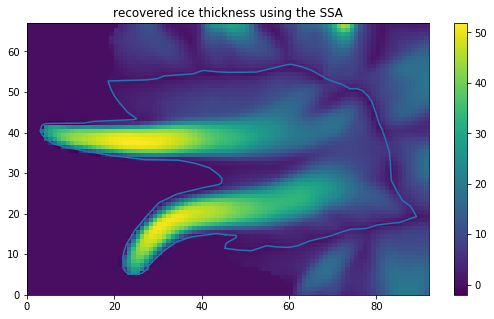

In [6]:
x = [(i[0]-outline.bbox[0])/res+6*resample for i in (outline).points[:]]
y = [(i[1]-outline.bbox[1])/res+10*resample for i in (outline).points[:]]
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x,y)
field = ax.pcolor(u_ref)
fig.colorbar(field)
ax.set_title('recovered ice thickness using the SSA')

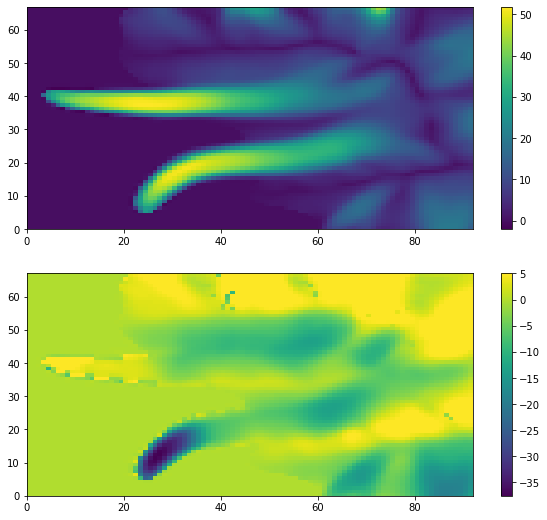

In [7]:
def plots(nrow=1, ncol=2, size=(10,4)):
    fig, axes = plt.subplots(nrow, ncol, figsize=size)
    for ax in axes:
        ax.set_aspect(1)
    return fig, axes

fig, axes = plt.subplots(2,1, figsize = (10,9))
field = axes[0].pcolor(u_ref, axes=axes[0])
fig.colorbar(field, ax=axes[0])
fi = axes[1].pcolor(v_vel_ref, axes=axes[1], vmax=5)
fig.colorbar(fi, ax=axes[1])


In [8]:
def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

<ipython-input-8-e081dd9c6ccd>:11: RuntimeWarning: invalid value encountered in true_divide
  Z=VV/WW


NameError: name 'dhdt_fit1' is not defined

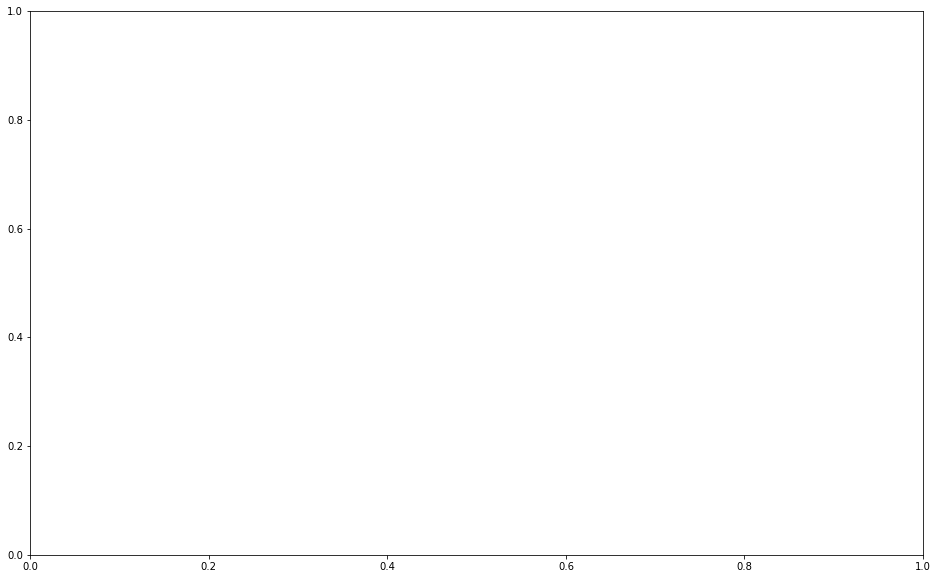

In [9]:
dhdt_corr = dhdt_ref + (np.sum(M_ref[mask==1])-np.sum(dhdt_ref[mask==1]))/len(np.where(mask==1)[0])
M_corr = M_ref + (np.sum(dhdt_ref[mask==1])-np.sum(M_ref[mask==1]))/len(np.where(mask==1)[0])
M_app = M_ref - dhdt_corr

M_app[mask==0] = np.nan
#M_app_c = convolve(M_app, np.ones((9,9)))
M_app_c = gauss_filter(M_app, 2, 4)
M_app[mask==0] = 0
M_app_c[mask==0] = 0

#M_app_c_acc = np.zeros_like(M_app)*np.nan
#M_app_c_acc[M_app>0] = M_app[M_app>0]
#M_app_c_acc = convolve(M_app_c_acc, np.ones((5,5)))
#M_app_c_acc[np.isnan(M_app_c_acc)]=0
#M_app_c_acc[M_app<0]=0
#
#M_app_c_abl = np.zeros_like(M_app)*np.nan
#M_app_c_abl[M_app<0] = M_app[M_app<0]
#M_app_c_abl = convolve(M_app_c_abl, np.ones((5,5)))
#M_app_c_abl[np.isnan(M_app_c_acc)]=0
#M_app_c_abl[M_app>0]=0
#
#M_app_c = M_app_c_acc + M_app_c_abl

### two different approaches to ensure that acc and abl are balanced:
## 1) correct by misfit between the two
M_app_corr = (M_app_c/np.sum(abs(M_app_c)))*np.sum(abs(M_app))
M_app_corr += (np.sum(M_app_corr[mask==1]))/len(np.where(mask==1)[0])

## 2) scale both seperately to reference mass balance (M_app)
M_app_corr_acc = np.zeros_like(M_app_c)
acc_area = M_app>0
acc_area_c = M_app_c>0
M_app_corr_acc[acc_area_c] = (M_app_c[acc_area_c]/np.sum(abs(M_app_c[acc_area_c])))*np.sum(abs(M_app[acc_area]))

M_app_corr_abl = np.zeros_like(M_app_c)
abl_area = M_app<0
abl_area_c = M_app_c<0
M_app_corr_abl[abl_area_c]=(M_app_c[abl_area_c]/np.sum(abs(M_app_c[abl_area_c])))*np.sum(abs(M_app[abl_area]))

M_app_corr = M_app_corr_acc + M_app_corr_abl

fig, ax = plt.subplots(figsize=(16,10))
field = ax.pcolor(M_ref - dhdt_fit1, cmap='RdBu', vmin=-4, vmax=4)
fig.colorbar(field)
ax.set_title('SMB')

-1157.2983812320729
-1645.229339187587
-703.6879943714255
 
0.005436 x - 7.106
           6             5             4             3             2
5.072e-18 x - 4.988e-14 x + 1.912e-10 x - 3.751e-07 x + 0.0004028 x - 0.2246 x + 49.58


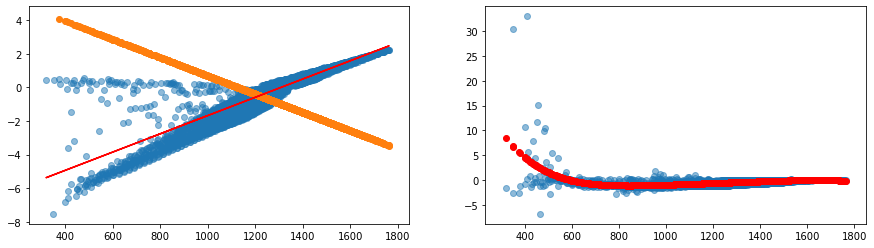

In [10]:
x = copy(S_ref)
crit_ref = ~np.logical_and(M_ref<0.1, M_ref>-0.1)
y = M_ref
#crit_app = ~np.logical_and(M_app_corr<0.1, M_app_corr>-0.1)
#y = M_app_corr[crit_app]
poly = np.poly1d(np.polyfit(x[crit_ref],y[crit_ref],1))

fig, ax = plt.subplots(1,2, figsize=(15,4))

ax[0].scatter(x[crit_ref], y[crit_ref], alpha=.5)
ax[0].plot(x[crit_ref],poly(x[crit_ref]), color='r')
print(np.sum(y*mask))

dhdt_fit = -poly(x)-.98
ax[0].scatter(x[mask==1], dhdt_fit[mask==1])
print(np.sum(dhdt_fit*mask))

ax[1].scatter(x[crit_ref], dhdt_ref[crit_ref], alpha=.5)
poly1 = np.poly1d(np.polyfit(x[crit_ref],dhdt_ref[crit_ref],6))
ax[1].scatter(x[crit_ref],poly1(x[crit_ref]), color='r')

dhdt_fit1 = poly1(x)+.11
print(np.sum(dhdt_fit1*mask))

print(poly)
print(poly1)

In [11]:
ice_temp = 265
A = 1.733e3*np.exp(-13.9e4/(8.3*ice_temp))
print(A)

6.209346546180128e-25


In [12]:
filename = "synthetic_conf.nc"
nc = NC(filename, 'w', format="NETCDF3_CLASSIC")
var = nc.createVariable("pism_overrides", 'i')

attrs = {"ocean.always_grounded": "yes",
         "geometry.update.use_basal_melt_rate": "no",
         "stress_balance.ssa.compute_surface_gradient_inward": "no",
         "flow_law.isothermal_Glen.ice_softness": A,
         "constants.ice.density": 900.,
         "constants.sea_water.density": 1000.,
         "bootstrapping.defaults.geothermal_flux": 0.0,
         "stress_balance.ssa.Glen_exponent": 3.,
         "constants.standard_gravity": 9.81,
         "ocean.sub_shelf_heat_flux_into_ice": 0.0,
         "stress_balance.sia.bed_smoother.range": 0.0,
         #"geometry.ice_free_thickness_standard": 30,
         }

for name, value in attrs.items():
    var.setncattr(name, value)

nc.close()

In [13]:
WRIT_FILE = 'synthetic_initialSetup.nc'

### CONSTANTS ###

secpera = 31556926.
ice_density = 900.0             # [kg m-3]

Lx = nx * res  # in m
Ly =  ny * res # in m

# grid size: extent in km's, origin (0,0) in the center of the domain

x = np.linspace(-Lx/2, Lx/2, nx)
y = np.linspace(-Ly/2, Ly/2, ny)

B_rec = S_ref
B_init = copy(B_rec)
ice_surface_temp = np.ones((ny, nx))*273
land_ice_area_fraction_retreat = np.ones_like(S_ref)
M_ref = np.nan_to_num(M_ref)
M_ref *= mask

h_rec = S_ref - B_rec

##### define variables, set attributes, write data #####
# format: ['units', 'long_name', 'standard_name', '_FillValue', array]

vars = {'y':    ['km',
                 'y-coordinate in Cartesian system',
                 'projection_y_coordinate',
                 None,
                 y],
        'x':    ['km',
                 'x-coordinate in Cartesian system',
                 'projection_x_coordinate',
                 None,
                 x],
        'thk':  ['m',
                 'ice thickness',
                 'land_ice_thickness',
                 1.0,
                 h_rec],
        'topg': ['m',
                 'bedrock surface elevation',
                 'bedrock_altitude',
                 0.0,
                 B_rec],
        'ice_surface_temp': ['K',
                             'annual mean air temperature at ice surface',
                             'surface_temperature',
                             273,
                             ice_surface_temp],
        'climatic_mass_balance': ['kg m-2 year-1',
                                  'mean annual net ice equivalent accumulation rate',
                                  'land_ice_surface_specific_mass_balance_flux',
                                  0,
                                  M_ref * ice_density],
        'land_ice_area_fraction_retreat': ['',
                                  'maximum ice extent mask',
                                  'land_ice_area_fraction_retreat',
                                  0,
                                  mask],
        }

##### define dimensions in NetCDF file #####
def create_nc_input(vars, WRIT_FILE):
    ncfile = NC(WRIT_FILE, 'w', format='NETCDF3_CLASSIC')
    xdim = ncfile.createDimension('x', nx)
    ydim = ncfile.createDimension('y', ny)
    
    for name in list(vars.keys()):
        [_, _, _, fill_value, data] = vars[name]
        if name in ['x', 'y']:
            var = ncfile.createVariable(name, 'f4', (name,))
        else:
            var = ncfile.createVariable(name, 'f4', ('y', 'x'), fill_value=fill_value)
        for each in zip(['units', 'long_name', 'standard_name'], vars[name]):
            if each[1]:
                setattr(var, each[0], each[1])
        var[:] = data
    
    # finish up
    ncfile.close()
    print("NetCDF file ", WRIT_FILE, " created")
    print('')
    
create_nc_input(vars, WRIT_FILE)

NetCDF file  synthetic_initialSetup.nc  created



In [15]:
def create_script(forward_or_iteration, nx, ny):
    print("""#!/bin/bash
    ###### run script for experiment synthetic1 ######""")
    print('# build the PISM command')
    print('set -e #exit on error')
    print('')
    print('NN="$1"')
    print('CLIMATEFILE="$2"')
    print('DURATION=$3')
    print('OUTNAME=$4')
    print('OPT5=$5')
    print('RUNTIME="-ys 0 -ye $DURATION"')
    
    print('')
    print('CLIMATE="-surface given -surface_given_file $CLIMATEFILE"')
    print('grid="-Mx {} -My {} -Mz 10 -Mbz 1 -Lz 1000 -Lbz 1"'.format(nx, ny))
    print('PHYS="-stress_balance ssa+sia -sia_flow_law isothermal_glen -ssa_flow_law isothermal_glen"')
    print('THERMAL="-energy none"')
    print('OCEAN="-dry"')
    print('CONF="-config_override synthetic_conf.nc"')# -front_retreat_file synthetic_max_extent.nc -geometry.front_retreat.prescribed.period 100"')
    #print('DIF="-limit_sia_diffusivity -stress_balance.sia.max_diffusivity $OPT5 -time_stepping.adaptive_ratio 0.12"')
    #print('ENHANCE="-sia_e 1e5 -sia_n 2 -ssa_e 10"')
    
    # power law sliding relation t_b=-C*|u|^(m-1)*u --> doesn't require thermal model
    print('SLIDING="-pseudo_plastic -pseudo_plastic_q 0.33333 -pseudo_plastic_uthreshold 3.1556926e7 -yield_stress constant -tauc 10e7"')
    
    print('echo')
    print('echo "# ======================================================================="')
    print('echo "# initialize synthetic glacier"')
    print('echo "#  $NN processors, $DURATION a run, 50 km grid, $CLIMATEFILE, $4"')
    print('echo "# ======================================================================="')
    
    print('')
    print('PISM_MPIDO="mpiexec -n "')
    
    print('')
    print('PISM_BIN=/home/thomas/pism/bin')
    print('PISM_EXEC="pismr"')
    print('EXVARS="temppabase,tempicethk_basal,velsurf_mag,mask,thk,usurf,velbase_mag"')
    
    print('')
    print('PISM="${PISM_BIN}/${PISM_EXEC}"')
    
    print('')
    print('EXSTEP=100')
    print('TSNAME=ts_$OUTNAME')
    print('TSTIMES=0:yearly:$DURATION')
    print('EXNAME=ex_$OUTNAME')
    print('EXTIMES=0:$EXSTEP:$DURATION')
    print('DIAGNOSTICS="-ts_file $TSNAME -ts_times $TSTIMES -extra_file $EXNAME -extra_times $EXTIMES -extra_vars $EXVARS"')
    
    print('DIAGNOSTICS_ITER="-save_file s_$OUTNAME -save_times $OPT5 -save_force_output_times"')

    
    print('')
    if forward_or_iteration == 'forward':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE -bootstrap ${grid} $CONF $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS -o $OUTNAME"')
    elif forward_or_iteration == 'iteration':
        print('cmd="$PISM_MPIDO $NN $PISM -i $CLIMATEFILE $CONF $DIF $ENHANCE $SLIDING $THERMAL $OCEAN $RUNTIME $CLIMATE $PHYS $DIAGNOSTICS_ITER -o $OUTNAME"')
    
    print('')
    print('echo')
    print('$cmd')

In [16]:
original_stdout = sys.stdout # Save a reference to the original standard output
with open('synthetic_initialize.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    create_script('forward', nx, ny)
    sys.stdout = original_stdout # Reset the standard output to its original value
    f.close()
    
#!chmod +x synthetic_initialize.sh
!./synthetic_initialize.sh 4 synthetic_initialSetup.nc 1 synthetic_output.nc > synthetic_output_log.txt

In [17]:
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = ds[var][time][:]
    return var_data

def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))

In [59]:
!cp synthetic_output.nc synthetic_test_in.nc
nc_test = NC('synthetic_test_in.nc', 'r+')
topg_def = get_nc_data('synthetic_output.nc', 'topg', 0)
thk_def = get_nc_data('synthetic_output.nc', 'thk', 0)
topg_adjust = copy(topg_def)
thk_adjust = copy(thk_def)
random_noise = np.random.rand(len(topg_adjust[mask==1]))*5
topg_adjust[mask==1] += random_noise
thk_adjust[mask==1] = np.maximum(0,thk_adjust[mask==1]-random_noise)
#topg_adjust[12:17, 70:80]+=10
#thk_adjust[12:17, 70:80]-=10
H[mask==0]=0
H = np.minimum(H, 250)
nc_test['topg'][0,:,:]= topg_adjust
nc_test['thk'][0,:,:]= thk_adjust+H
nc_test.close()

In [238]:
original_stdout = sys.stdout
with open('synthetic_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    

In [254]:
dts = [.25]#, .5, 1, 2, 3, 5, 7, 10, 15]
dt_fields = []
h_outs = []
h_outs_dot1 =[]
for i,t in enumerate(dts):
    cmd = ["./synthetic_iteration_script.sh", '7', 'synthetic_test_in.nc', str(t+.1), 'synthetic_iteration_out.nc', str(t)]
    subprocess.call(cmd, stdout=open('synthetic_iteration_log.txt', 'a'))
    
    h_outs.append(get_nc_data('s_synthetic_iteration_out.nc', 'thk', -1))
    h_outs_dot1.append(get_nc_data('synthetic_iteration_out.nc', 'thk', 0))
    dt_fields.append(h_outs_dot1[i]-h_outs[i])

Text(0.5, 1.0, 'difference between neighboring dhdt values, measured after x years')

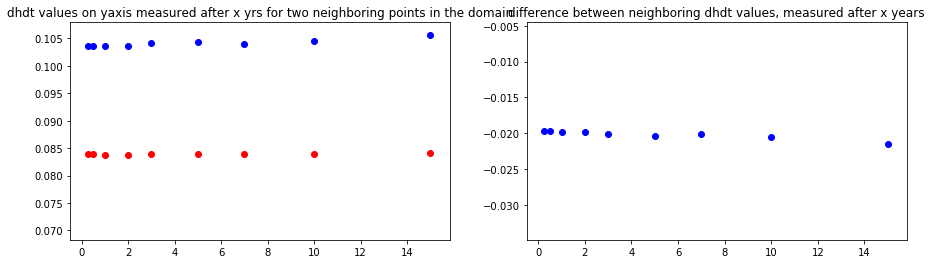

In [208]:
r, c = 50,50
r1, c1 = 51,50
fig, ax = plt.subplots(1,2, figsize=(15,4))
for i in range(len(dts)-1):
    ax[0].scatter(dts[i],dt_fields[i][r,c], color='r')
    ax[0].scatter(dts[i],dt_fields[i][r1,c1], color='b')
    ax[1].scatter(dts[i],dt_fields[i][r,c]-dt_fields[i][r1,c1], color='b')
    
ax[0].set_title('dhdt values on yaxis measured after x yrs for two neighboring points in the domain')
ax[1].set_title('difference between neighboring dhdt values, measured after x years')

In [18]:
## shifted dhdt-field
from scipy.interpolate import griddata

def shift(data, u, v, dx):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
    x_shift = x_shift+(u/uv_mag)*dx
    y_shift = y_shift+(v/uv_mag)*dx

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten())).reshape(np.shape(u))
    return newgrid

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
1.7635959101522491


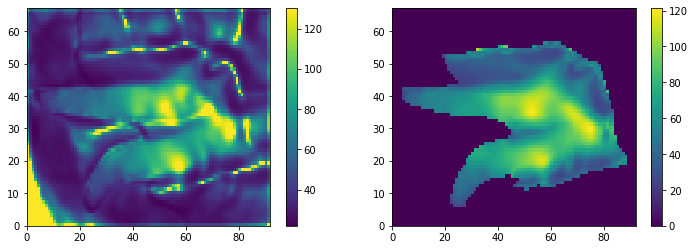

In [19]:
import richdem as rd
import math

kernel = np.ones((3, 3))
S_ref_s = ndimage.convolve(S_ref, kernel)/(3)**2

dH = (np.max(S_ref*mask)-np.min(S_ref*mask))/1000 #in km

tau = 0.005+1.598*dH-0.435*dH**2  #Haeberli and Hoelzle

slope = rd.TerrainAttribute(rd.rdarray(S_ref, no_data=-9999), attrib='slope_riserun')
tan_slope = np.arctan(slope/res)
sin_slope = np.sin(tan_slope)
H=tau*1e5/(sin_slope*9.81*ice_density)
fig, ax = plt.subplots(1,2, figsize=(12,4))
field = ax[0].pcolor(H, vmax = 130)
fig.colorbar(field, ax = ax[0])
print(dH)

def smooth_stress_coupling(H, field, mask, scl, max_scl):
    field_new = np.zeros_like(field)
    for i in range(nx):
        for j in range(ny):
            if mask[j,i]==0:
                field_new[j,i] = field[j,i]
            else:
                x, y = np.ogrid[:np.shape(H)[0], :np.shape(H)[1]]
                coupling_length = scl*(H[j,i]/res)**2
                circle = (y - i) ** 2 + (x - j) ** 2 <= (min(coupling_length,max_scl)/2)**2
                field_new[j,i]= np.mean(field[np.logical_and(circle, mask==1)])
    return field_new
            
sin_slope_smooth = smooth_stress_coupling(H, sin_slope, mask, 4, 8)
H_smooth=(tau)*1e5/(sin_slope_smooth*9.81*ice_density)
field = ax[1].pcolor(H_smooth*mask)
fig.colorbar(field, ax=ax[1])

In [65]:
### bed recovery ###
from scipy.signal import spline_filter

S_ref = np.flip(np.loadtxt("02_surface_Synthetic1_0000_UTM00.asc", skiprows=6), axis=0)
S_ref[S_ref == nan_value] = 0
S_ref = zoom(S_ref, resample)
S_rec = copy(S_ref)

B_rec = np.maximum(S_ref-300, S_ref-H_smooth*mask)
B_init = copy(B_rec)

dh_ref = copy(dhdt_ref*mask)
#dh_ref = np.zeros_like(dhdt_ref)

B_rec_all = []
dh_all = []
misfit_all = []
B_misfit_vs_iter=[]
dh_misfit_vs_iter=[]
S_rec_all = []

pmax = 300
dt = .1
beta = .5
bw = 4

!cp synthetic_output.nc synthetic_iteration_out.nc
    
original_stdout = sys.stdout
with open('synthetic_iteration_script.sh', 'w') as f:
    sys.stdout = f
    create_script('iteration', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_iteration_script.sh

In [66]:
for p in tqdm.trange(0, pmax):
    
    h_old = S_rec - B_rec
        
    !cp synthetic_iteration_out.nc synthetic_iteration_in.nc
    nc_updated = NC('synthetic_iteration_in.nc', 'r+')
    nc_updated['topg'][0,:,:]=B_rec
    nc_updated['thk'][0,:,:]=h_old
    nc_updated.close()
    
    cmd = ["./synthetic_iteration_script.sh", '4', 'synthetic_iteration_in.nc', str(dt), 'synthetic_iteration_out.nc', str(dt/2)]
    subprocess.call(cmd, stdout=open('synthetic_iteration_log.txt', 'a'))
    
    #h_rec2 = get_nc_data('s_synthetic_iteration_out.nc', 'thk', -1)
    h_rec = get_nc_data('synthetic_iteration_out.nc', 'thk', 0)
    dh_rec = (h_rec - h_old)/dt
    
    mask_iter = get_nc_data('synthetic_iteration_out.nc', 'mask', 0)/2 #base buffer on ice mask produced by PISM --> faster than loop
    k = np.ones((bw, bw))
    buffer = ndimage.convolve(mask_iter, k)/(bw)**2 #smooth ice mask...
    criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)

    u = get_nc_data('synthetic_iteration_out.nc', 'uvelsurf', 0)
    u[criterion] = 0
    v = get_nc_data('synthetic_iteration_out.nc', 'vvelsurf', 0)
    v[criterion] = 0
    #criterion = np.where(np.logical_and(mask_iter+shift(mask_iter, u, v, -2)>1, mask_iter+shift(mask_iter, u, v, -2)<2)) 

    misfit = shift((dh_rec-dh_ref), u, v, .3)
    #misfit = dh_rec - dh_ref
    #misfit/=(5+get_nc_data('synthetic_iteration_out.nc', 'velbar_mag', 0))

    #misfit = spline_filter(misfit, lmbda=.1)

    misfit_lowpass = ndimage.gaussian_filter(misfit, 1)
    misfit_highpass = misfit - misfit_lowpass
    
    B_rec -= beta * (misfit)
    S_rec[np.logical_and(mask==1, h_rec>20)] += (beta*.05) * misfit[np.logical_and(mask==1, h_rec>20)] 
    
    H_rec = S_rec - B_rec
    H_rec = ndimage.gaussian_filter(H_rec, 1, truncate=1)
    B_rec = S_rec - H_rec

    #if p%100 == 0:
    #    S_rec = copy(S_ref)
    
    ### buffer ###

    h_inpaint = S_rec-B_rec
    h_inpaint[criterion] = np.nan #...and take those values in the transition between ice and no ice;
    h_inpaint = inpaint_nans(h_inpaint)
    B_rec = S_rec - h_inpaint
    ### buffer end ###
    
    #B_rec[mask==1]=np.minimum(S_ref[mask==1]-50, B_rec[mask==1])
    B_rec[B_rec>S_rec]=S_rec[B_rec>S_rec]
    B_rec[B_rec>S_ref]=S_rec[B_rec>S_ref]
    S_rec[mask == 0]= S_ref[mask == 0]
    B_rec[mask == 0]= S_ref[mask == 0]
    
    B_rec_all.append(B_rec)
    dh_all.append(dh_rec)
    misfit_all.append(misfit)
    S_rec_all.append(S_rec)
    
    B_misfit_vs_iter.append(np.mean(abs(B_rec-B_init)))
    dh_misfit_vs_iter.append(np.mean(abs(dh_rec[mask==1]-dh_ref[mask==1])))

  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-18-b753abce6fae>:7: RuntimeWarning: invalid value encountered in sqrt
  uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
100%|██████████| 300/300 [06:09<00:00,  1.23s/it]


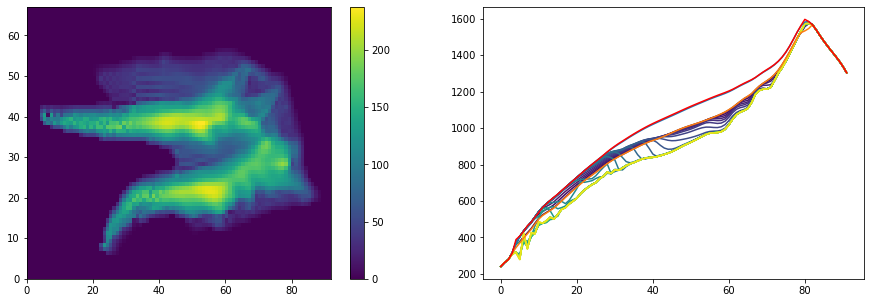

In [67]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_rec - B_rec)
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),10):
    lines = axes[1].plot(range(nx), B_rec_all[i][40,:], color=colors[i])
lines2 = axes[1].plot(range(nx), S_ref[40,:])
lines2 = axes[1].plot(range(nx), B_init[40,:])
lines2 = axes[1].plot(range(nx), S_rec[40,:], color='r')

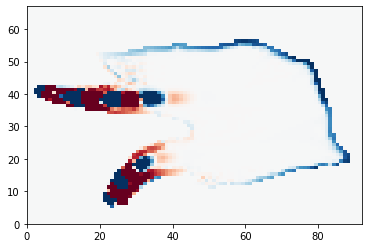

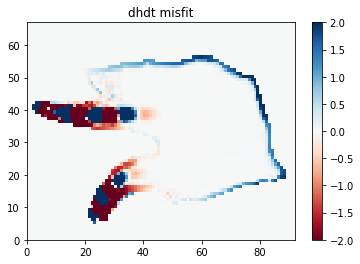

In [60]:
fig, axes = plt.subplots()
for i in range(0,len(B_rec_all),10):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-2, vmax=2)
    clear_output(wait=True)
    display(fig)
axes.set_title('dhdt misfit')
fig.colorbar(field)

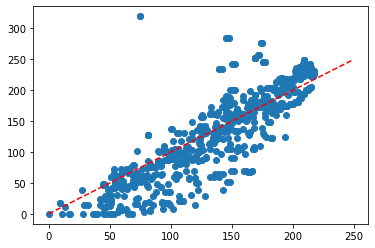

In [61]:
x_new = ((x_coord-outline.bbox[0])/res+6*resample).astype('int')
y_new = ((y_coord-outline.bbox[1])/res+10*resample).astype('int')
cors = []
thk_rec_all = []
for i in range(0,len(B_rec_all),1):
    thk_rec = S_rec_all[i] - B_rec_all[i]#ndimage.convolve(S_ref-B_rec_all[-1], np.ones((4,4))/16)
    thk_rec_all.append(thk_rec)
    cors.append(np.corrcoef(thick, thk_rec[y_new,x_new])[0][1])

fig, ax = plt.subplots()
field = ax.scatter(thick, thk_rec_all[-1][y_new, x_new])
#ax.set_aspect(1)
#ax.set_xlim([0,np.max(thick)])
#ax.set_ylim([0,np.max(thick)])
ax.plot(range(250), range(250), 'r', linestyle='--')


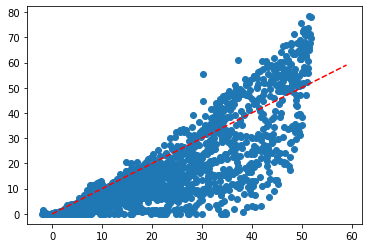

In [25]:
fig, ax = plt.subplots()
field = ax.scatter(u_ref, get_nc_data('synthetic_iteration_out.nc', 'velsurf_mag', 0))
ax.plot(range(60), range(60), 'r', linestyle='--')

In [89]:
import scipy.stats as st
max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thk_rec_all[-1][y_new,x_new]-thick)/96.3 #96.3 is mean thickness according to ITMIX2, and value used therein
mean_dev = np.nanmean((dev))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
print('mean deviation: {}'.format(mean_dev))
print('median deviation: {}'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

mean deviation: -0.06704117332920267
median deviation: -0.0704429506906554
Interquartile range of deviation: 0.23577109548892813
95% confidence intervall: [ 0.01384692 -0.01384692]


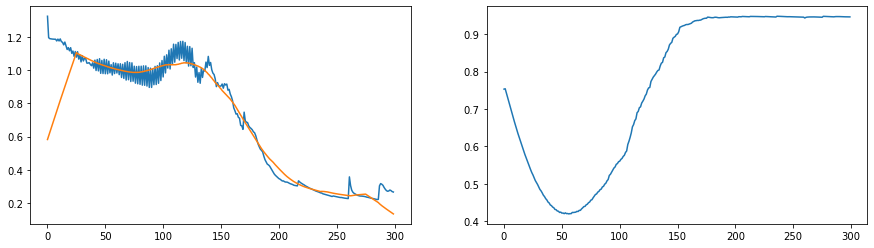

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
line = ax[0].plot(dh_misfit_vs_iter)
line1 = ax[0].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))
line2 = ax[1].plot(cors)

In [ ]:
data = misfit
data[mask==0] = np.nan
data = scale(data)

data2 = slope
data2[mask==0] = np.nan
data2 = scale(data2)

dt_field = dh_all[-1250]-dh_ref
dt_field[mask==0] = np.nan
dt_field = scale(dt_field)

fig, ax = plt.subplots(1,2, figsize=(15,4))
field2 = ax[0].plot(range(ny), data[:,50])
field = ax[0].plot(range(ny), dt_field[:,50], color='orange')
ax1 = ax[0].twinx()
field2 = ax1.plot(range(ny), data2[:,50], color='r')


line = ax[1].plot(range(ny), data[:,50])
ax2 = ax[1].twinx()
line1 = ax2.plot(range(ny), dt_field[:,50], color='orange')

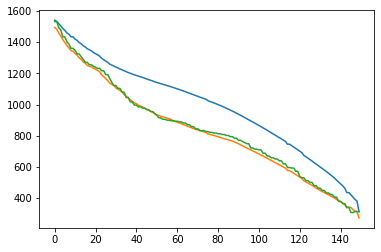

In [32]:
p = 12

x_test = [int((x-outline.bbox[0])/res+6*resample) for x in (x_coord[indPro[p]])]
y_test = [int((x-outline.bbox[1])/res+10*resample) for x in (y_coord[indPro[p]])]

fig, axes = plt.subplots()
surf_ref = axes.plot(z_surf[indPro[p]])
bed_ref = axes.plot(z_bed[indPro[p]])
bed_rec = axes.plot(S_ref[y_test, x_test]-(S_ref[y_test, x_test]-B_rec[y_test, x_test]))

<ipython-input-18-7bcef971f392>:15: RuntimeWarning: divide by zero encountered in true_divide
  ts = ((2*0.12)/(D*mask*(1/100**2+1/100**2)))/secpera


0.04311816162279427
0.2696538999566359
-0.5481373719594995


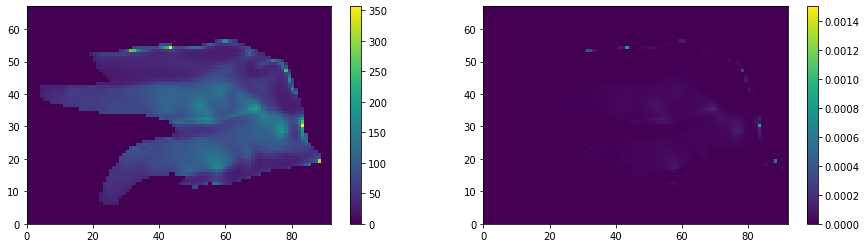

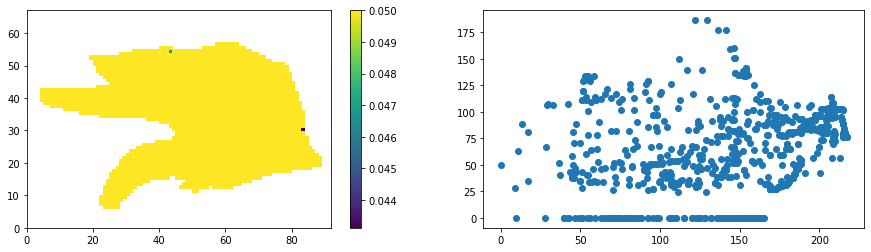

In [18]:
#compute diffusivity
T=(2*A*(9.8*ice_density)**3)/5
D=mask*T*H**5*(slope/100)**2
H[D>1e-3] = np.nan
H_fill = inpaint_nans(H)
H_fill*=mask
D=T*H_fill**5*(slope/100)**2
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(H_fill)#, vmax = 1.5e-3)
field2 = ax[1].pcolor(D, vmax = 1.5e-3)
fig.colorbar(field, ax=ax[0])
fig.colorbar(field2, ax=ax[1])

##time step
ts = ((2*0.12)/(D*mask*(1/100**2+1/100**2)))/secpera
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].pcolor(ts, vmax=.05)
fig.colorbar(field, ax=ax[0])
field2 = ax[1].scatter(thick, H_fill[y_new, x_new])
print(np.nanmin(ts))
print(np.corrcoef(thick, H_fill[y_new,x_new])[0][1])
print(np.mean(((H_fill[y_new,x_new]-thick)/np.mean(thick))))

In [193]:
### grow glacier on smoothed reconstructed bed
B_recs2=ndimage.convolve(B_rec_all[-1], np.ones((6,6)))/36#get_nc_data('synthetic_build_out.nc', 'topg', 0)
M_ref2 = np.flip(np.loadtxt("04_mb_Synthetic1_0000-0001_UTM00.asc", skiprows=6), axis=0)
M_ref2[M_ref2 == nan_value] = -1
M_ref2 = zoom(M_ref2, resample)
M_ref2[mask == 0] = -1

nc_restart = NC('synthetic_initialSetup.nc', 'r+')
nc_restart['thk'][:,:] = np.zeros_like(S_ref)
nc_restart['topg'][:,:] = B_recs2
nc_restart['climatic_mass_balance'][:,:] = M_ref2 * ice_density
nc_restart.close()

original_stdout = sys.stdout
with open('synthetic_build_script.sh', 'w') as f:
    sys.stdout = f
    create_script('forward', nx, ny)
    sys.stdout = original_stdout
    f.close()
    
!chmod +x synthetic_build_script.sh
    
cmd = ["./synthetic_build_script.sh", '4', 'synthetic_initialSetup.nc', str(1200), 'synthetic_build_out.nc']
subprocess.call(cmd, stdout=open('synthetic_build_log.txt', 'w'))

0

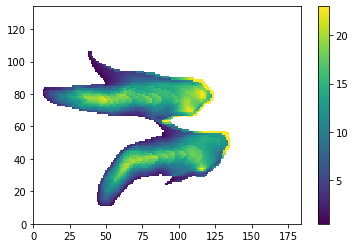

In [379]:
abl_area = np.zeros_like(M_ref)*np.nan
abl_area[(M_ref)<0] = 1
dis_abl = np.zeros_like(M_ref)*np.nan
for i in np.argwhere(abl_area==1):
    d = np.argmin(cdist(np.array([[i[0], i[1]]]), x))
    dis_abl[i[0], i[1]]=np.linalg.norm(x[d]-i)
    
bin_raster = np.round(M_ref/2.315,1)*abl_area
bin_M = (np.unique(bin_raster))
nbins = len(np.nonzero(~np.isnan(np.unique(bin_raster)))[0])
bin_M = bin_M[np.arange(nbins)]
area = []
slope_abl = np.zeros_like(M_ref)*np.nan
slope_abl[M_ref<0]=-slope[M_ref<0]+1
for i in range(nbins):
    area.append(np.sum(abl_area[bin_raster==bin_M[i]]))
    dis_sum = np.sum(dis_abl[bin_raster==bin_M[i]])
    dis_abl[bin_raster==bin_M[i]]/=dis_sum
    slope_sum = np.sum(slope_abl[bin_raster==bin_M[i]])
    slope_abl[bin_raster==bin_M[i]]/=slope_sum
    
acc_sum = np.nansum(acc_area*M_ref)
abl_thk = (dis_abl+slope_abl)/2
mass_content = []
abl_cum = acc_sum
for i in reversed(range(nbins)):
    mass_content.append(abl_cum)
    abl_thk[bin_raster==bin_M[i]]*=abl_cum
    abl_cum+=area[i]*bin_M[i]
    
abl_thk=np.minimum(abl_thk, np.nanmean(abl_thk)+2*np.nanstd(abl_thk))

fig, ax = plt.subplots()
field = ax.pcolor(abl_thk)
fig.colorbar(field)

[3, 9.3, 53.3, 178.7, 299.3, 503.3, 728.9000000000001, 931.4000000000001, 1126.0, 1324.9, 1549.3000000000002, 1792.4, 2059.4, 2270.9, 2491.7000000000003, 2690.5000000000005, 2884.9000000000005, 3095.4000000000005, 3261.4000000000005, 3379.6000000000004, 3464.8, 3504.4]


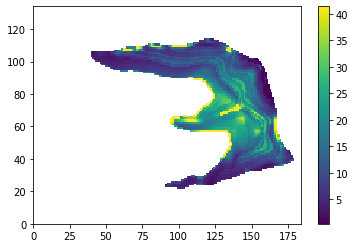

In [250]:
acc_area = np.zeros_like(M_ref)*np.nan
acc_area[(M_ref)>0] = 1
dis_acc = np.zeros_like(M_ref)*np.nan
for i in np.argwhere(acc_area==1):
    d = np.argmin(cdist(np.array([[i[0], i[1]]]), x))
    dis_acc[i[0], i[1]]=np.linalg.norm(x[d]-i)

bin_raster = np.round(M_ref/1.1,1)*acc_area
bin_M = (np.unique(bin_raster))
nbins = len(np.nonzero(~np.isnan(np.unique(bin_raster)))[0])
bin_M = bin_M[np.arange(nbins)]
area = []
slope_acc = np.zeros_like(M_ref)*np.nan
slope_acc[M_ref>0]=-slope[M_ref>0]+1
for i in range(nbins):
    area.append(np.sum(acc_area[bin_raster==bin_M[i]]))
    dis_sum = np.sum(dis_acc[bin_raster==bin_M[i]])
    dis_acc[bin_raster==bin_M[i]]/=dis_sum
    slope_sum = np.sum(slope_acc[bin_raster==bin_M[i]])
    slope_acc[bin_raster==bin_M[i]]/=slope_sum

acc_sum = np.sum(bin_raster==bin_M[nbins-1])#np.nansum(acc_area*M_ref)
acc_thk = (dis_acc+slope_acc)
mass_content = []
abl_cum = acc_sum
for i in reversed(range(nbins)):
    mass_content.append(abl_cum)
    acc_thk[bin_raster==bin_M[i]]*=abl_cum
    abl_cum+=area[i]*bin_M[i]
    
acc_thk=np.minimum(acc_thk, np.nanmean(acc_thk)+2*np.nanstd(acc_thk))
print(mass_content)    
fig, ax = plt.subplots()
field = ax.pcolor(acc_thk)
fig.colorbar(field)

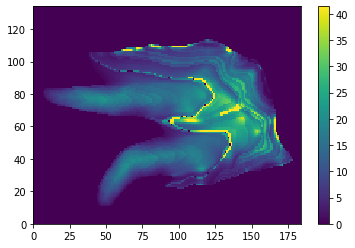

In [252]:
abl_thk[np.isnan(abl_thk)]=0
acc_thk[np.isnan(acc_thk)]=0
comb_thk = abl_thk+acc_thk
fig, ax = plt.subplots()
field = ax.pcolor(comb_thk)
fig.colorbar(field)

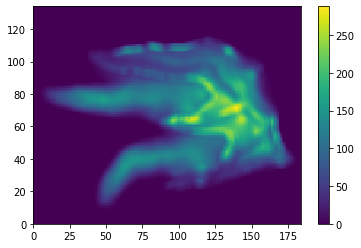

In [350]:
k = np.ones((5, 5))
comb_s = ndimage.convolve(comb_thk, k)/(5)**2
fig, ax = plt.subplots()
field = ax.pcolor(comb_s*8)
fig.colorbar(field)

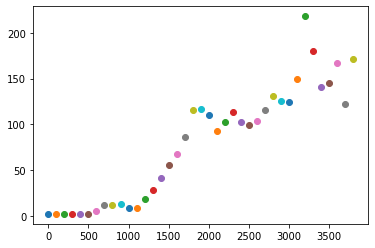

In [583]:
for i in range(0,len(dh_all),100):
    plt.scatter(i,np.max(dh_all[i]))

In [ ]:
from scipy import signal
def inpaint_nans(im):
    nans = np.isnan(im)
    ipn_kernel = np.array([[1,1,1],[1,0,1],[1,1,1]]) # kernel for inpaint_nans
    while np.sum(nans)>0:
        im[nans] = 0
        vNeighbors = signal.convolve2d((nans==False),ipn_kernel,mode='same',boundary='symm')
        im2 = signal.convolve2d(im,ipn_kernel,mode='same',boundary='symm')
        im2[vNeighbors>0] = im2[vNeighbors>0]/vNeighbors[vNeighbors>0]
        im2[vNeighbors==0] = np.nan
        im2[(nans==False)] = im[(nans==False)]
        im = im2
        nans = np.isnan(im)
    return im